# Code for how to use the model

In [10]:
# Import packages
import numpy as np                                                                                  # For data manipulation 
import tensorflow as tf                                                                             # For building the model
import tensorflow_decision_forests as tfdf                                                          # For building the model
import rasterio                                                                                     # For reading raster files
import earthpy.plot as ep                                                                           # For plotting the data
from matplotlib.colors import from_levels_and_colors                                                # For plotting the data
import os                                                                                           # For setting environment variables
import pandas as pd                                                                                 # For data manipulation
import matplotlib.pyplot as plt                                                                     # For plotting the data

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [11]:
# variables

PLOT_SIZE = (8, 8)
ALL_FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'NDVI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI', 'elevation']
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080', '#90EE90', '#228B22', '#808000', '#006400', '#FF8C00']
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_CLASSES = len(CLASSES)
NUM_OF_BANDS = len(FEATURES)
MODEL = "RF" # CNN or RF
MODEL_NAME = 'NDVI_CNN_V1.keras' if MODEL == 'CNN' else 'NDVI_RF_V1'
MODEL_PATH = 'saved_data/' + MODEL_NAME
IMAGE_PATH = 'ndvi_data/Landsat_Jogja_2023_ALLFEATURES.tif'

In [12]:
if (MODEL == "CNN"):
  model = tf.keras.models.load_model(MODEL_PATH) 
else:
  model = tf.saved_model.load(MODEL_PATH)

2024-12-02 09:44:46.166647: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1206] Loading model from path saved_data/NDVI_RF_V1/assets/ with prefix 217825af0bb7449c
I0000 00:00:1733107494.848607  153399 decision_forest.cc:761] Model loaded with 50 root(s), 22626 node(s), and 15 input feature(s).
I0000 00:00:1733107494.851803  153399 abstract_model.cc:1404] Engine "RandomForestGeneric" built
2024-12-02 09:44:54.851848: I tensorflow_decision_forests/tensorflow/ops/inference/kernel.cc:1035] Use fast generic engine


In [13]:
# Function to reshape array input
def reshape_input(array):
    return np.expand_dims(array, axis=-1)

In [14]:
if (MODEL == 'CNN'):
    image = rasterio.open(IMAGE_PATH)

    bandNum = image.count
    height = image.height
    width = image.width
    crs = image.crs
    transform = image.transform
    shape = (height, width)

    image_input = []
    used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
    for i in used_image_feature:
        image_input.append(image.read(i))
    image_input = reshape_input(np.stack(image_input).reshape(NUM_OF_BANDS, -1).T)

    # Predict
    # prediction = model.predict(image_input, batch_size=4096*20)
    prediction = model.predict(image_input, batch_size=4096)
    image_predicted_classes = np.argmax(prediction, 1)
    image_predicted_classes = image_predicted_classes.reshape(shape[0], shape[1])
    image_predicted_classes += 1

    # Visualize
    cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
    ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=PLOT_SIZE)

<_PrefetchDataset element_spec={'B1': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B2': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B5': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B6': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'B7': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'EVI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NBR': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NDMI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NDWI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NDBI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NDBaI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'NDVI': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'elevation': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>


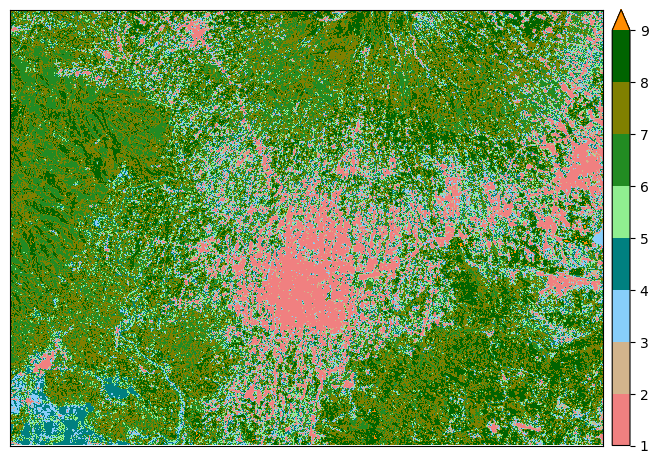

In [15]:
if (MODEL == 'RF'):
    # Load image
    image = rasterio.open(IMAGE_PATH)
    
    bandNum = image.count
    height = image.height
    width = image.width
    crs = image.crs
    transform = image.transform
    shape = (height, width)

    image_data = []

    used_image_feature = [i + 1 for i in range(0, len(ALL_FEATURES)) if image.descriptions[i] in FEATURES]
    for i in used_image_feature:
        band_data = image.read(i).flatten()
        image_data.append(band_data)

    # Create DataFrame for image data
    image_df = pd.DataFrame(np.array(image_data).T, columns=[word for word in FEATURES])
    image_df['elevation'] = image_df['elevation'].astype(np.int64)
    
    # Convert to TensorFlow dataset
    image_ds = tfdf.keras.pd_dataframe_to_tf_dataset(image_df)

    print(image_ds)

    # Use the dictionary as input to the model
    prediction = model(dict(image_df))
    image_predicted_classes = np.argmax(prediction, axis=1)

    # Reshape predictions to image dimensions
    image_predicted_classes = image_predicted_classes.reshape(shape)

    # Visualize the predictions
    cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
    ep.plot_bands(image_predicted_classes, cmap=cmap, norm=norm, figsize=(8, 8))
    plt.show()

In [16]:
# Save file to drive
save_location = 'saved_data/'
name = f'Output_{MODEL}.tif'
location = save_location + name

# Save the classified image to a file
with rasterio.open(
    location,
    'w',
    driver='GTiff',
    height=shape[0],
    width=shape[1],
    count=1,
    dtype=image_predicted_classes.dtype.name,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(image_predicted_classes, 1)

print('File saved to ' + location)

File saved to saved_data/Output_RF.tif


{'driver': 'GTiff', 'dtype': 'int64', 'nodata': None, 'width': 1856, 'height': 1364, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 110.12842326746228,
       0.0, -0.00026949458523585647, -7.563365534644312), 'blockxsize': 1856, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


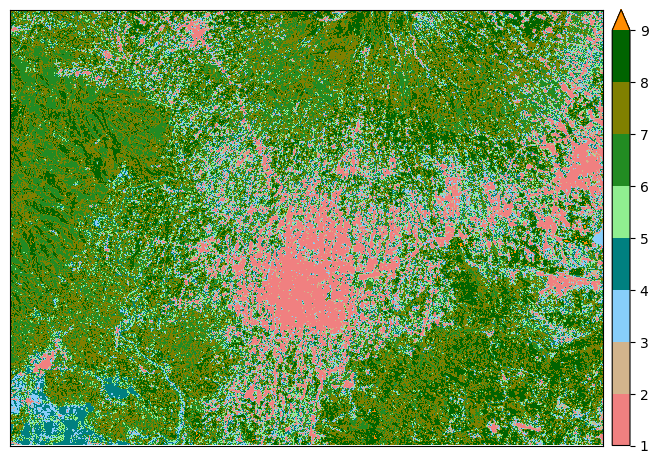

In [17]:
test_open_output = rasterio.open(location)

print(test_open_output.profile)

ep.plot_bands(test_open_output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()

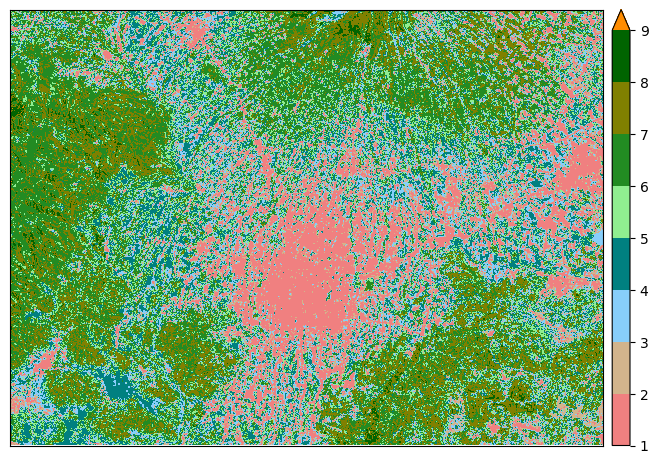

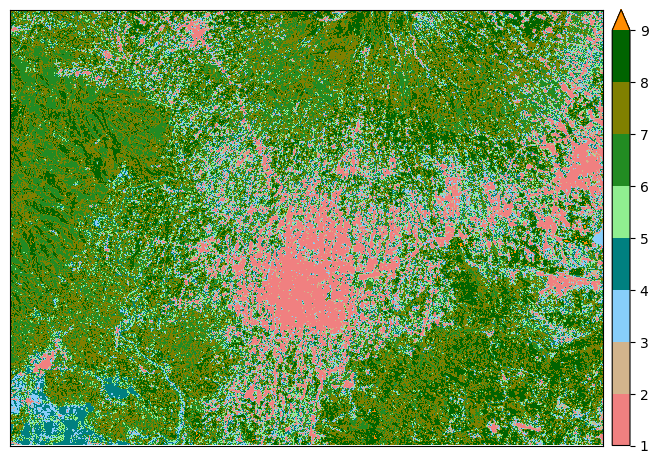

{'driver': 'GTiff', 'dtype': 'int64', 'nodata': None, 'width': 1856, 'height': 1364, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00026949458523585647, 0.0, 110.12842326746228,
       0.0, -0.00026949458523585647, -7.563365534644312)}


In [19]:
# CNN vs RNN

CNN_Output = rasterio.open('saved_data/Output_CNN.tif')
RNN_Output = rasterio.open('saved_data/Output_RF.tif')

ep.plot_bands(CNN_Output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()
ep.plot_bands(RNN_Output.read(1), cmap=cmap, norm=norm, figsize=PLOT_SIZE)
plt.show()

print(RNN_Output.meta)